In [ ]:
# !pip install -U scikit-image
!pip install imutils

In [ ]:
UseAllowGrowth = True
UseGPUnum = "0"

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]= str(UseGPUnum)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'

if(UseAllowGrowth):
    from tensorflow.compat.v1 import ConfigProto
    from tensorflow.compat.v1 import InteractiveSession
    config = ConfigProto()
    config.gpu_options.allow_growth = True
    session = InteractiveSession(config=config)

# Show GPU info
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

In [4]:
import mrcnn 
from PIL import Image
from mrcnn.utils import Dataset
from mrcnn.model import MaskRCNN
from mrcnn.config import Config
from mrcnn import model as modellib
from mrcnn import visualize

import os

In [6]:

# class_label =1: pedestrians
# class_label =2: riders
# class_label =3: partially-visible persons
# class_label =4: ignore regions
# class_label =5: crowd

import numpy as np
from numpy import zeros
from numpy import asarray
import colorsys
import argparse
import imutils
import random
import os
import time
from matplotlib import pyplot
from matplotlib.patches import Rectangle
from keras.models import load_model
%matplotlib inline
from os import listdir


class PedestrianDataset(Dataset):
    # load the dataset definitions
    def load_dataset(self, dataset_dir, is_train=True):
        
        # Add classes. We have only one class to add.
        self.add_class("dataset", 1, "pedestrians")
        self.add_class("dataset", 2, "riders")
        self.add_class("dataset", 3, "pvp")
        self.add_class("dataset", 4, "ignore")
        self.add_class("dataset", 5, "crowd")
        
        # define data locations for images and annotations
        images_dir = dataset_dir + '/Images/'
        annotations_dir = dataset_dir + '/Annotations/'
        
        # Iterate through all files in the folder to 
        #add class, images and annotaions
        count = 0
        for filename in listdir(images_dir):
            
            # extract image id
            image_id = filename.split(".")[0]
            
            # setting image file
            img_path = images_dir + filename
            
            # setting annotations file
            ann_path = annotations_dir + image_id + '.jpg.txt'
            try:
              file = open(ann_path)
              count+=1
              # skip all images after 1500 if we are building the train set
              if is_train and count >= 6001:
                  continue
              # skip all images before 150 if we are building the test/val set
              if not is_train and (count < 6001 or count >= 7501):
                continue 
              # adding images and annotations to dataset
              self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)
            except FileNotFoundError:
              print("File with: "+ ann_path + " not found")
            
            
# extract bounding boxes from an annotation file
    def extract_boxes(self, image_id):
        
        # extract each bounding box
        boxes = list()
        class_ids = list()

        annot_name_path = self.image_info[image_id]['annotation']
        img_name_path = self.image_info[image_id]['path']
        print(img_name_path)
        count = 0
        with open(annot_name_path) as file: 
          for line in file: 
              if count == 0:
                  count+=1
              else:
                  class_ids.append(line.strip().split(" ")[0])
                  coors = line.strip().split(" ")[1:5]
                  coors = [int(x) for x in coors]
                  boxes.append(coors)
        
        im = Image.open(img_name_path)
        width, height = im.size

        return class_ids, boxes, width, height
    # load the masks for an image
    """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
     """
    def load_mask(self, image_id):
        # get details of image
        info = self.image_info[image_id]
        print(info)

        # define anntation  file location
        # path = info['annotation']
        
        # load bounding boxes
        class_ids, boxes, w, h = self.extract_boxes(image_id)
       
        # create one array for all masks, each on a different channel
        masks = zeros([h, w, len(boxes)], dtype='uint8')
        
        # create masks
        for i in range(len(boxes)):
            box = boxes[i]
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]
            masks[row_s:row_e, col_s:col_e, i] = 1

        return masks, asarray(class_ids, dtype='int32')
    
    # load an image reference
    """Return the path of the image."""
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        print(info)
        return info['path']

In [7]:
# prepare train set
train_set = PedestrianDataset()
train_set.load_dataset("WiderPerson", is_train=True)
train_set.prepare()

# prepare test/val set
test_set = PedestrianDataset()
test_set.load_dataset("WiderPerson", is_train=False)
test_set.prepare()

print("Train: %d" % len(train_set.image_ids))
print("Test: %d" % len(test_set.image_ids))

File with: WiderPerson/Annotations/000043.jpg.txt not found
File with: WiderPerson/Annotations/000047.jpg.txt not found
File with: WiderPerson/Annotations/000052.jpg.txt not found
File with: WiderPerson/Annotations/000053.jpg.txt not found
File with: WiderPerson/Annotations/000054.jpg.txt not found
File with: WiderPerson/Annotations/000055.jpg.txt not found
File with: WiderPerson/Annotations/000056.jpg.txt not found
File with: WiderPerson/Annotations/000057.jpg.txt not found
File with: WiderPerson/Annotations/000058.jpg.txt not found
File with: WiderPerson/Annotations/000064.jpg.txt not found
File with: WiderPerson/Annotations/000066.jpg.txt not found
File with: WiderPerson/Annotations/000067.jpg.txt not found
File with: WiderPerson/Annotations/000068.jpg.txt not found
File with: WiderPerson/Annotations/000069.jpg.txt not found
File with: WiderPerson/Annotations/000070.jpg.txt not found
File with: WiderPerson/Annotations/000071.jpg.txt not found
File with: WiderPerson/Annotations/00007

File with: WiderPerson/Annotations/001142.jpg.txt not found
File with: WiderPerson/Annotations/001150.jpg.txt not found
File with: WiderPerson/Annotations/001163.jpg.txt not found
File with: WiderPerson/Annotations/001170.jpg.txt not found
File with: WiderPerson/Annotations/001172.jpg.txt not found
File with: WiderPerson/Annotations/001184.jpg.txt not found
File with: WiderPerson/Annotations/001186.jpg.txt not found
File with: WiderPerson/Annotations/001187.jpg.txt not found
File with: WiderPerson/Annotations/001190.jpg.txt not found
File with: WiderPerson/Annotations/001202.jpg.txt not found
File with: WiderPerson/Annotations/001203.jpg.txt not found
File with: WiderPerson/Annotations/001206.jpg.txt not found
File with: WiderPerson/Annotations/001208.jpg.txt not found
File with: WiderPerson/Annotations/001210.jpg.txt not found
File with: WiderPerson/Annotations/001212.jpg.txt not found
File with: WiderPerson/Annotations/001248.jpg.txt not found
File with: WiderPerson/Annotations/00125

File with: WiderPerson/Annotations/003495.jpg.txt not found
File with: WiderPerson/Annotations/003502.jpg.txt not found
File with: WiderPerson/Annotations/003505.jpg.txt not found
File with: WiderPerson/Annotations/003509.jpg.txt not found
File with: WiderPerson/Annotations/003510.jpg.txt not found
File with: WiderPerson/Annotations/003511.jpg.txt not found
File with: WiderPerson/Annotations/003512.jpg.txt not found
File with: WiderPerson/Annotations/003515.jpg.txt not found
File with: WiderPerson/Annotations/003516.jpg.txt not found
File with: WiderPerson/Annotations/003517.jpg.txt not found
File with: WiderPerson/Annotations/003526.jpg.txt not found
File with: WiderPerson/Annotations/003528.jpg.txt not found
File with: WiderPerson/Annotations/003529.jpg.txt not found
File with: WiderPerson/Annotations/003530.jpg.txt not found
File with: WiderPerson/Annotations/003531.jpg.txt not found
File with: WiderPerson/Annotations/003536.jpg.txt not found
File with: WiderPerson/Annotations/00353

File with: WiderPerson/Annotations/004058.jpg.txt not found
File with: WiderPerson/Annotations/004061.jpg.txt not found
File with: WiderPerson/Annotations/004064.jpg.txt not found
File with: WiderPerson/Annotations/004070.jpg.txt not found
File with: WiderPerson/Annotations/004072.jpg.txt not found
File with: WiderPerson/Annotations/004074.jpg.txt not found
File with: WiderPerson/Annotations/004076.jpg.txt not found
File with: WiderPerson/Annotations/004101.jpg.txt not found
File with: WiderPerson/Annotations/004110.jpg.txt not found
File with: WiderPerson/Annotations/004127.jpg.txt not found
File with: WiderPerson/Annotations/004141.jpg.txt not found
File with: WiderPerson/Annotations/004150.jpg.txt not found
File with: WiderPerson/Annotations/004163.jpg.txt not found
File with: WiderPerson/Annotations/004166.jpg.txt not found
File with: WiderPerson/Annotations/004168.jpg.txt not found
File with: WiderPerson/Annotations/004175.jpg.txt not found
File with: WiderPerson/Annotations/00440

File with: WiderPerson/Annotations/005740.jpg.txt not found
File with: WiderPerson/Annotations/005743.jpg.txt not found
File with: WiderPerson/Annotations/005748.jpg.txt not found
File with: WiderPerson/Annotations/005749.jpg.txt not found
File with: WiderPerson/Annotations/005754.jpg.txt not found
File with: WiderPerson/Annotations/005755.jpg.txt not found
File with: WiderPerson/Annotations/005762.jpg.txt not found
File with: WiderPerson/Annotations/005764.jpg.txt not found
File with: WiderPerson/Annotations/005766.jpg.txt not found
File with: WiderPerson/Annotations/005767.jpg.txt not found
File with: WiderPerson/Annotations/005769.jpg.txt not found
File with: WiderPerson/Annotations/005775.jpg.txt not found
File with: WiderPerson/Annotations/005778.jpg.txt not found
File with: WiderPerson/Annotations/005780.jpg.txt not found
File with: WiderPerson/Annotations/005781.jpg.txt not found
File with: WiderPerson/Annotations/005788.jpg.txt not found
File with: WiderPerson/Annotations/00579

File with: WiderPerson/Annotations/007519.jpg.txt not found
File with: WiderPerson/Annotations/007520.jpg.txt not found
File with: WiderPerson/Annotations/007521.jpg.txt not found
File with: WiderPerson/Annotations/007523.jpg.txt not found
File with: WiderPerson/Annotations/007536.jpg.txt not found
File with: WiderPerson/Annotations/007539.jpg.txt not found
File with: WiderPerson/Annotations/007554.jpg.txt not found
File with: WiderPerson/Annotations/007555.jpg.txt not found
File with: WiderPerson/Annotations/007558.jpg.txt not found
File with: WiderPerson/Annotations/007562.jpg.txt not found
File with: WiderPerson/Annotations/007568.jpg.txt not found
File with: WiderPerson/Annotations/007588.jpg.txt not found
File with: WiderPerson/Annotations/007615.jpg.txt not found
File with: WiderPerson/Annotations/007616.jpg.txt not found
File with: WiderPerson/Annotations/007617.jpg.txt not found
File with: WiderPerson/Annotations/007621.jpg.txt not found
File with: WiderPerson/Annotations/00762

File with: WiderPerson/Annotations/008688.jpg.txt not found
File with: WiderPerson/Annotations/008690.jpg.txt not found
File with: WiderPerson/Annotations/008691.jpg.txt not found
File with: WiderPerson/Annotations/008693.jpg.txt not found
File with: WiderPerson/Annotations/008695.jpg.txt not found
File with: WiderPerson/Annotations/008696.jpg.txt not found
File with: WiderPerson/Annotations/008697.jpg.txt not found
File with: WiderPerson/Annotations/008698.jpg.txt not found
File with: WiderPerson/Annotations/008699.jpg.txt not found
File with: WiderPerson/Annotations/008700.jpg.txt not found
File with: WiderPerson/Annotations/008701.jpg.txt not found
File with: WiderPerson/Annotations/008703.jpg.txt not found
File with: WiderPerson/Annotations/008706.jpg.txt not found
File with: WiderPerson/Annotations/008708.jpg.txt not found
File with: WiderPerson/Annotations/008710.jpg.txt not found
File with: WiderPerson/Annotations/008711.jpg.txt not found
File with: WiderPerson/Annotations/00871

File with: WiderPerson/Annotations/009472.jpg.txt not found
File with: WiderPerson/Annotations/009478.jpg.txt not found
File with: WiderPerson/Annotations/009483.jpg.txt not found
File with: WiderPerson/Annotations/009487.jpg.txt not found
File with: WiderPerson/Annotations/009489.jpg.txt not found
File with: WiderPerson/Annotations/009492.jpg.txt not found
File with: WiderPerson/Annotations/009495.jpg.txt not found
File with: WiderPerson/Annotations/009497.jpg.txt not found
File with: WiderPerson/Annotations/009522.jpg.txt not found
File with: WiderPerson/Annotations/009523.jpg.txt not found
File with: WiderPerson/Annotations/009524.jpg.txt not found
File with: WiderPerson/Annotations/009525.jpg.txt not found
File with: WiderPerson/Annotations/009526.jpg.txt not found
File with: WiderPerson/Annotations/009536.jpg.txt not found
File with: WiderPerson/Annotations/009546.jpg.txt not found
File with: WiderPerson/Annotations/009547.jpg.txt not found
File with: WiderPerson/Annotations/00955

File with: WiderPerson/Annotations/010207.jpg.txt not found
File with: WiderPerson/Annotations/010208.jpg.txt not found
File with: WiderPerson/Annotations/010209.jpg.txt not found
File with: WiderPerson/Annotations/010211.jpg.txt not found
File with: WiderPerson/Annotations/010213.jpg.txt not found
File with: WiderPerson/Annotations/010215.jpg.txt not found
File with: WiderPerson/Annotations/010217.jpg.txt not found
File with: WiderPerson/Annotations/010219.jpg.txt not found
File with: WiderPerson/Annotations/010220.jpg.txt not found
File with: WiderPerson/Annotations/010221.jpg.txt not found
File with: WiderPerson/Annotations/010224.jpg.txt not found
File with: WiderPerson/Annotations/010227.jpg.txt not found
File with: WiderPerson/Annotations/010229.jpg.txt not found
File with: WiderPerson/Annotations/010231.jpg.txt not found
File with: WiderPerson/Annotations/010236.jpg.txt not found
File with: WiderPerson/Annotations/010247.jpg.txt not found
File with: WiderPerson/Annotations/01024

File with: WiderPerson/Annotations/010847.jpg.txt not found
File with: WiderPerson/Annotations/010848.jpg.txt not found
File with: WiderPerson/Annotations/010853.jpg.txt not found
File with: WiderPerson/Annotations/010857.jpg.txt not found
File with: WiderPerson/Annotations/010866.jpg.txt not found
File with: WiderPerson/Annotations/010870.jpg.txt not found
File with: WiderPerson/Annotations/010872.jpg.txt not found
File with: WiderPerson/Annotations/010877.jpg.txt not found
File with: WiderPerson/Annotations/010881.jpg.txt not found
File with: WiderPerson/Annotations/010882.jpg.txt not found
File with: WiderPerson/Annotations/010883.jpg.txt not found
File with: WiderPerson/Annotations/010891.jpg.txt not found
File with: WiderPerson/Annotations/010892.jpg.txt not found
File with: WiderPerson/Annotations/010893.jpg.txt not found
File with: WiderPerson/Annotations/010901.jpg.txt not found
File with: WiderPerson/Annotations/010903.jpg.txt not found
File with: WiderPerson/Annotations/01090

File with: WiderPerson/Annotations/012113.jpg.txt not found
File with: WiderPerson/Annotations/012115.jpg.txt not found
File with: WiderPerson/Annotations/012124.jpg.txt not found
File with: WiderPerson/Annotations/012125.jpg.txt not found
File with: WiderPerson/Annotations/012126.jpg.txt not found
File with: WiderPerson/Annotations/012138.jpg.txt not found
File with: WiderPerson/Annotations/012139.jpg.txt not found
File with: WiderPerson/Annotations/012141.jpg.txt not found
File with: WiderPerson/Annotations/012144.jpg.txt not found
File with: WiderPerson/Annotations/012148.jpg.txt not found
File with: WiderPerson/Annotations/012149.jpg.txt not found
File with: WiderPerson/Annotations/012150.jpg.txt not found
File with: WiderPerson/Annotations/012153.jpg.txt not found
File with: WiderPerson/Annotations/012154.jpg.txt not found
File with: WiderPerson/Annotations/012156.jpg.txt not found
File with: WiderPerson/Annotations/012157.jpg.txt not found
File with: WiderPerson/Annotations/01216

File with: WiderPerson/Annotations/012482.jpg.txt not found
File with: WiderPerson/Annotations/012491.jpg.txt not found
File with: WiderPerson/Annotations/012497.jpg.txt not found
File with: WiderPerson/Annotations/012502.jpg.txt not found
File with: WiderPerson/Annotations/012514.jpg.txt not found
File with: WiderPerson/Annotations/012516.jpg.txt not found
File with: WiderPerson/Annotations/012519.jpg.txt not found
File with: WiderPerson/Annotations/012521.jpg.txt not found
File with: WiderPerson/Annotations/012524.jpg.txt not found
File with: WiderPerson/Annotations/012526.jpg.txt not found
File with: WiderPerson/Annotations/012529.jpg.txt not found
File with: WiderPerson/Annotations/012531.jpg.txt not found
File with: WiderPerson/Annotations/012534.jpg.txt not found
File with: WiderPerson/Annotations/012536.jpg.txt not found
File with: WiderPerson/Annotations/012538.jpg.txt not found
File with: WiderPerson/Annotations/012543.jpg.txt not found
File with: WiderPerson/Annotations/01255

File with: WiderPerson/Annotations/013983.jpg.txt not found
File with: WiderPerson/Annotations/013988.jpg.txt not found
File with: WiderPerson/Annotations/013997.jpg.txt not found
File with: WiderPerson/Annotations/014002.jpg.txt not found
File with: WiderPerson/Annotations/014019.jpg.txt not found
File with: WiderPerson/Annotations/014029.jpg.txt not found
File with: WiderPerson/Annotations/014071.jpg.txt not found
File with: WiderPerson/Annotations/014079.jpg.txt not found
File with: WiderPerson/Annotations/014081.jpg.txt not found
File with: WiderPerson/Annotations/014089.jpg.txt not found
File with: WiderPerson/Annotations/014129.jpg.txt not found
File with: WiderPerson/Annotations/014134.jpg.txt not found
File with: WiderPerson/Annotations/014137.jpg.txt not found
File with: WiderPerson/Annotations/014138.jpg.txt not found
File with: WiderPerson/Annotations/014140.jpg.txt not found
File with: WiderPerson/Annotations/014152.jpg.txt not found
File with: WiderPerson/Annotations/01415

File with: WiderPerson/Annotations/014784.jpg.txt not found
File with: WiderPerson/Annotations/014787.jpg.txt not found
File with: WiderPerson/Annotations/014790.jpg.txt not found
File with: WiderPerson/Annotations/014792.jpg.txt not found
File with: WiderPerson/Annotations/014793.jpg.txt not found
File with: WiderPerson/Annotations/014798.jpg.txt not found
File with: WiderPerson/Annotations/014800.jpg.txt not found
File with: WiderPerson/Annotations/014806.jpg.txt not found
File with: WiderPerson/Annotations/014807.jpg.txt not found
File with: WiderPerson/Annotations/014815.jpg.txt not found
File with: WiderPerson/Annotations/014816.jpg.txt not found
File with: WiderPerson/Annotations/014818.jpg.txt not found
File with: WiderPerson/Annotations/014826.jpg.txt not found
File with: WiderPerson/Annotations/014829.jpg.txt not found
File with: WiderPerson/Annotations/014830.jpg.txt not found
File with: WiderPerson/Annotations/014832.jpg.txt not found
File with: WiderPerson/Annotations/01483

File with: WiderPerson/Annotations/016050.jpg.txt not found
File with: WiderPerson/Annotations/016058.jpg.txt not found
File with: WiderPerson/Annotations/016067.jpg.txt not found
File with: WiderPerson/Annotations/016069.jpg.txt not found
File with: WiderPerson/Annotations/016081.jpg.txt not found
File with: WiderPerson/Annotations/016088.jpg.txt not found
File with: WiderPerson/Annotations/016095.jpg.txt not found
File with: WiderPerson/Annotations/016097.jpg.txt not found
File with: WiderPerson/Annotations/016099.jpg.txt not found
File with: WiderPerson/Annotations/016106.jpg.txt not found
File with: WiderPerson/Annotations/016119.jpg.txt not found
File with: WiderPerson/Annotations/016124.jpg.txt not found
File with: WiderPerson/Annotations/016126.jpg.txt not found
File with: WiderPerson/Annotations/016135.jpg.txt not found
File with: WiderPerson/Annotations/016137.jpg.txt not found
File with: WiderPerson/Annotations/016144.jpg.txt not found
File with: WiderPerson/Annotations/01615

File with: WiderPerson/Annotations/016836.jpg.txt not found
File with: WiderPerson/Annotations/016838.jpg.txt not found
File with: WiderPerson/Annotations/016842.jpg.txt not found
File with: WiderPerson/Annotations/016845.jpg.txt not found
File with: WiderPerson/Annotations/016848.jpg.txt not found
File with: WiderPerson/Annotations/016850.jpg.txt not found
File with: WiderPerson/Annotations/016851.jpg.txt not found
File with: WiderPerson/Annotations/016855.jpg.txt not found
File with: WiderPerson/Annotations/016856.jpg.txt not found
File with: WiderPerson/Annotations/016863.jpg.txt not found
File with: WiderPerson/Annotations/016868.jpg.txt not found
File with: WiderPerson/Annotations/016870.jpg.txt not found
File with: WiderPerson/Annotations/016872.jpg.txt not found
File with: WiderPerson/Annotations/016876.jpg.txt not found
File with: WiderPerson/Annotations/016881.jpg.txt not found
File with: WiderPerson/Annotations/016884.jpg.txt not found
File with: WiderPerson/Annotations/01689

File with: WiderPerson/Annotations/017896.jpg.txt not found
File with: WiderPerson/Annotations/017905.jpg.txt not found
File with: WiderPerson/Annotations/017906.jpg.txt not found
File with: WiderPerson/Annotations/017907.jpg.txt not found
File with: WiderPerson/Annotations/017910.jpg.txt not found
File with: WiderPerson/Annotations/017921.jpg.txt not found
File with: WiderPerson/Annotations/017925.jpg.txt not found
File with: WiderPerson/Annotations/017926.jpg.txt not found
File with: WiderPerson/Annotations/017929.jpg.txt not found
File with: WiderPerson/Annotations/017930.jpg.txt not found
File with: WiderPerson/Annotations/017931.jpg.txt not found
File with: WiderPerson/Annotations/017932.jpg.txt not found
File with: WiderPerson/Annotations/017935.jpg.txt not found
File with: WiderPerson/Annotations/017938.jpg.txt not found
File with: WiderPerson/Annotations/017941.jpg.txt not found
File with: WiderPerson/Annotations/017942.jpg.txt not found
File with: WiderPerson/Annotations/01795

File with: WiderPerson/Annotations/019003.jpg.txt not found
File with: WiderPerson/Annotations/019009.jpg.txt not found
File with: WiderPerson/Annotations/019017.jpg.txt not found
File with: WiderPerson/Annotations/019020.jpg.txt not found
File with: WiderPerson/Annotations/019027.jpg.txt not found
File with: WiderPerson/Annotations/019035.jpg.txt not found
File with: WiderPerson/Annotations/019039.jpg.txt not found
File with: WiderPerson/Annotations/019047.jpg.txt not found
File with: WiderPerson/Annotations/019048.jpg.txt not found
File with: WiderPerson/Annotations/019049.jpg.txt not found
File with: WiderPerson/Annotations/019054.jpg.txt not found
File with: WiderPerson/Annotations/019061.jpg.txt not found
File with: WiderPerson/Annotations/019065.jpg.txt not found
File with: WiderPerson/Annotations/019068.jpg.txt not found
File with: WiderPerson/Annotations/019071.jpg.txt not found
File with: WiderPerson/Annotations/019074.jpg.txt not found
File with: WiderPerson/Annotations/01908

File with: WiderPerson/Annotations/019983.jpg.txt not found
File with: WiderPerson/Annotations/019986.jpg.txt not found
File with: WiderPerson/Annotations/019987.jpg.txt not found
File with: WiderPerson/Annotations/019988.jpg.txt not found
File with: WiderPerson/Annotations/019991.jpg.txt not found
File with: WiderPerson/Annotations/019995.jpg.txt not found
File with: WiderPerson/Annotations/019997.jpg.txt not found
File with: WiderPerson/Annotations/019998.jpg.txt not found
File with: WiderPerson/Annotations/020000.jpg.txt not found
File with: WiderPerson/Annotations/020005.jpg.txt not found
File with: WiderPerson/Annotations/020008.jpg.txt not found
File with: WiderPerson/Annotations/020011.jpg.txt not found
File with: WiderPerson/Annotations/020014.jpg.txt not found
File with: WiderPerson/Annotations/020021.jpg.txt not found
File with: WiderPerson/Annotations/020024.jpg.txt not found
File with: WiderPerson/Annotations/020027.jpg.txt not found
File with: WiderPerson/Annotations/02003

File with: WiderPerson/Annotations/000047.jpg.txt not found
File with: WiderPerson/Annotations/000052.jpg.txt not found
File with: WiderPerson/Annotations/000053.jpg.txt not found
File with: WiderPerson/Annotations/000054.jpg.txt not found
File with: WiderPerson/Annotations/000055.jpg.txt not found
File with: WiderPerson/Annotations/000056.jpg.txt not found
File with: WiderPerson/Annotations/000057.jpg.txt not found
File with: WiderPerson/Annotations/000058.jpg.txt not found
File with: WiderPerson/Annotations/000064.jpg.txt not found
File with: WiderPerson/Annotations/000066.jpg.txt not found
File with: WiderPerson/Annotations/000067.jpg.txt not found
File with: WiderPerson/Annotations/000068.jpg.txt not found
File with: WiderPerson/Annotations/000069.jpg.txt not found
File with: WiderPerson/Annotations/000070.jpg.txt not found
File with: WiderPerson/Annotations/000071.jpg.txt not found
File with: WiderPerson/Annotations/000072.jpg.txt not found
File with: WiderPerson/Annotations/00007

File with: WiderPerson/Annotations/001668.jpg.txt not found
File with: WiderPerson/Annotations/001669.jpg.txt not found
File with: WiderPerson/Annotations/001675.jpg.txt not found
File with: WiderPerson/Annotations/001691.jpg.txt not found
File with: WiderPerson/Annotations/001702.jpg.txt not found
File with: WiderPerson/Annotations/001703.jpg.txt not found
File with: WiderPerson/Annotations/001706.jpg.txt not found
File with: WiderPerson/Annotations/001709.jpg.txt not found
File with: WiderPerson/Annotations/001711.jpg.txt not found
File with: WiderPerson/Annotations/001716.jpg.txt not found
File with: WiderPerson/Annotations/001719.jpg.txt not found
File with: WiderPerson/Annotations/001720.jpg.txt not found
File with: WiderPerson/Annotations/001724.jpg.txt not found
File with: WiderPerson/Annotations/001732.jpg.txt not found
File with: WiderPerson/Annotations/001742.jpg.txt not found
File with: WiderPerson/Annotations/001749.jpg.txt not found
File with: WiderPerson/Annotations/00176

File with: WiderPerson/Annotations/003765.jpg.txt not found
File with: WiderPerson/Annotations/003768.jpg.txt not found
File with: WiderPerson/Annotations/003770.jpg.txt not found
File with: WiderPerson/Annotations/003771.jpg.txt not found
File with: WiderPerson/Annotations/003772.jpg.txt not found
File with: WiderPerson/Annotations/003773.jpg.txt not found
File with: WiderPerson/Annotations/003774.jpg.txt not found
File with: WiderPerson/Annotations/003775.jpg.txt not found
File with: WiderPerson/Annotations/003777.jpg.txt not found
File with: WiderPerson/Annotations/003779.jpg.txt not found
File with: WiderPerson/Annotations/003780.jpg.txt not found
File with: WiderPerson/Annotations/003783.jpg.txt not found
File with: WiderPerson/Annotations/003785.jpg.txt not found
File with: WiderPerson/Annotations/003786.jpg.txt not found
File with: WiderPerson/Annotations/003787.jpg.txt not found
File with: WiderPerson/Annotations/003788.jpg.txt not found
File with: WiderPerson/Annotations/00379

File with: WiderPerson/Annotations/005037.jpg.txt not found
File with: WiderPerson/Annotations/005041.jpg.txt not found
File with: WiderPerson/Annotations/005042.jpg.txt not found
File with: WiderPerson/Annotations/005050.jpg.txt not found
File with: WiderPerson/Annotations/005053.jpg.txt not found
File with: WiderPerson/Annotations/005061.jpg.txt not found
File with: WiderPerson/Annotations/005073.jpg.txt not found
File with: WiderPerson/Annotations/005074.jpg.txt not found
File with: WiderPerson/Annotations/005076.jpg.txt not found
File with: WiderPerson/Annotations/005083.jpg.txt not found
File with: WiderPerson/Annotations/005086.jpg.txt not found
File with: WiderPerson/Annotations/005088.jpg.txt not found
File with: WiderPerson/Annotations/005097.jpg.txt not found
File with: WiderPerson/Annotations/005099.jpg.txt not found
File with: WiderPerson/Annotations/005100.jpg.txt not found
File with: WiderPerson/Annotations/005109.jpg.txt not found
File with: WiderPerson/Annotations/00511

File with: WiderPerson/Annotations/006315.jpg.txt not found
File with: WiderPerson/Annotations/006339.jpg.txt not found
File with: WiderPerson/Annotations/006372.jpg.txt not found
File with: WiderPerson/Annotations/006409.jpg.txt not found
File with: WiderPerson/Annotations/006417.jpg.txt not found
File with: WiderPerson/Annotations/006457.jpg.txt not found
File with: WiderPerson/Annotations/006474.jpg.txt not found
File with: WiderPerson/Annotations/006477.jpg.txt not found
File with: WiderPerson/Annotations/006487.jpg.txt not found
File with: WiderPerson/Annotations/006512.jpg.txt not found
File with: WiderPerson/Annotations/006533.jpg.txt not found
File with: WiderPerson/Annotations/006536.jpg.txt not found
File with: WiderPerson/Annotations/006553.jpg.txt not found
File with: WiderPerson/Annotations/006579.jpg.txt not found
File with: WiderPerson/Annotations/006581.jpg.txt not found
File with: WiderPerson/Annotations/006592.jpg.txt not found
File with: WiderPerson/Annotations/00660

File with: WiderPerson/Annotations/007616.jpg.txt not found
File with: WiderPerson/Annotations/007617.jpg.txt not found
File with: WiderPerson/Annotations/007621.jpg.txt not found
File with: WiderPerson/Annotations/007624.jpg.txt not found
File with: WiderPerson/Annotations/007638.jpg.txt not found
File with: WiderPerson/Annotations/007649.jpg.txt not found
File with: WiderPerson/Annotations/007656.jpg.txt not found
File with: WiderPerson/Annotations/007663.jpg.txt not found
File with: WiderPerson/Annotations/007664.jpg.txt not found
File with: WiderPerson/Annotations/007671.jpg.txt not found
File with: WiderPerson/Annotations/007672.jpg.txt not found
File with: WiderPerson/Annotations/007678.jpg.txt not found
File with: WiderPerson/Annotations/007683.jpg.txt not found
File with: WiderPerson/Annotations/007684.jpg.txt not found
File with: WiderPerson/Annotations/007689.jpg.txt not found
File with: WiderPerson/Annotations/007694.jpg.txt not found
File with: WiderPerson/Annotations/00769

File with: WiderPerson/Annotations/008798.jpg.txt not found
File with: WiderPerson/Annotations/008800.jpg.txt not found
File with: WiderPerson/Annotations/008801.jpg.txt not found
File with: WiderPerson/Annotations/008803.jpg.txt not found
File with: WiderPerson/Annotations/008804.jpg.txt not found
File with: WiderPerson/Annotations/008805.jpg.txt not found
File with: WiderPerson/Annotations/008808.jpg.txt not found
File with: WiderPerson/Annotations/008809.jpg.txt not found
File with: WiderPerson/Annotations/008810.jpg.txt not found
File with: WiderPerson/Annotations/008811.jpg.txt not found
File with: WiderPerson/Annotations/008813.jpg.txt not found
File with: WiderPerson/Annotations/008816.jpg.txt not found
File with: WiderPerson/Annotations/008818.jpg.txt not found
File with: WiderPerson/Annotations/008819.jpg.txt not found
File with: WiderPerson/Annotations/008822.jpg.txt not found
File with: WiderPerson/Annotations/008823.jpg.txt not found
File with: WiderPerson/Annotations/00882

File with: WiderPerson/Annotations/010055.jpg.txt not found
File with: WiderPerson/Annotations/010057.jpg.txt not found
File with: WiderPerson/Annotations/010060.jpg.txt not found
File with: WiderPerson/Annotations/010061.jpg.txt not found
File with: WiderPerson/Annotations/010062.jpg.txt not found
File with: WiderPerson/Annotations/010065.jpg.txt not found
File with: WiderPerson/Annotations/010068.jpg.txt not found
File with: WiderPerson/Annotations/010069.jpg.txt not found
File with: WiderPerson/Annotations/010072.jpg.txt not found
File with: WiderPerson/Annotations/010075.jpg.txt not found
File with: WiderPerson/Annotations/010076.jpg.txt not found
File with: WiderPerson/Annotations/010077.jpg.txt not found
File with: WiderPerson/Annotations/010080.jpg.txt not found
File with: WiderPerson/Annotations/010081.jpg.txt not found
File with: WiderPerson/Annotations/010084.jpg.txt not found
File with: WiderPerson/Annotations/010086.jpg.txt not found
File with: WiderPerson/Annotations/01009

File with: WiderPerson/Annotations/010857.jpg.txt not found
File with: WiderPerson/Annotations/010866.jpg.txt not found
File with: WiderPerson/Annotations/010870.jpg.txt not found
File with: WiderPerson/Annotations/010872.jpg.txt not found
File with: WiderPerson/Annotations/010877.jpg.txt not found
File with: WiderPerson/Annotations/010881.jpg.txt not found
File with: WiderPerson/Annotations/010882.jpg.txt not found
File with: WiderPerson/Annotations/010883.jpg.txt not found
File with: WiderPerson/Annotations/010891.jpg.txt not found
File with: WiderPerson/Annotations/010892.jpg.txt not found
File with: WiderPerson/Annotations/010893.jpg.txt not found
File with: WiderPerson/Annotations/010901.jpg.txt not found
File with: WiderPerson/Annotations/010903.jpg.txt not found
File with: WiderPerson/Annotations/010908.jpg.txt not found
File with: WiderPerson/Annotations/010916.jpg.txt not found
File with: WiderPerson/Annotations/010921.jpg.txt not found
File with: WiderPerson/Annotations/01093

File with: WiderPerson/Annotations/012100.jpg.txt not found
File with: WiderPerson/Annotations/012107.jpg.txt not found
File with: WiderPerson/Annotations/012113.jpg.txt not found
File with: WiderPerson/Annotations/012115.jpg.txt not found
File with: WiderPerson/Annotations/012124.jpg.txt not found
File with: WiderPerson/Annotations/012125.jpg.txt not found
File with: WiderPerson/Annotations/012126.jpg.txt not found
File with: WiderPerson/Annotations/012138.jpg.txt not found
File with: WiderPerson/Annotations/012139.jpg.txt not found
File with: WiderPerson/Annotations/012141.jpg.txt not found
File with: WiderPerson/Annotations/012144.jpg.txt not found
File with: WiderPerson/Annotations/012148.jpg.txt not found
File with: WiderPerson/Annotations/012149.jpg.txt not found
File with: WiderPerson/Annotations/012150.jpg.txt not found
File with: WiderPerson/Annotations/012153.jpg.txt not found
File with: WiderPerson/Annotations/012154.jpg.txt not found
File with: WiderPerson/Annotations/01215

File with: WiderPerson/Annotations/012965.jpg.txt not found
File with: WiderPerson/Annotations/012967.jpg.txt not found
File with: WiderPerson/Annotations/012970.jpg.txt not found
File with: WiderPerson/Annotations/012971.jpg.txt not found
File with: WiderPerson/Annotations/012973.jpg.txt not found
File with: WiderPerson/Annotations/012975.jpg.txt not found
File with: WiderPerson/Annotations/012977.jpg.txt not found
File with: WiderPerson/Annotations/012978.jpg.txt not found
File with: WiderPerson/Annotations/012980.jpg.txt not found
File with: WiderPerson/Annotations/012983.jpg.txt not found
File with: WiderPerson/Annotations/012989.jpg.txt not found
File with: WiderPerson/Annotations/012996.jpg.txt not found
File with: WiderPerson/Annotations/012998.jpg.txt not found
File with: WiderPerson/Annotations/012999.jpg.txt not found
File with: WiderPerson/Annotations/013003.jpg.txt not found
File with: WiderPerson/Annotations/013004.jpg.txt not found
File with: WiderPerson/Annotations/01300

File with: WiderPerson/Annotations/014029.jpg.txt not found
File with: WiderPerson/Annotations/014071.jpg.txt not found
File with: WiderPerson/Annotations/014079.jpg.txt not found
File with: WiderPerson/Annotations/014081.jpg.txt not found
File with: WiderPerson/Annotations/014089.jpg.txt not found
File with: WiderPerson/Annotations/014129.jpg.txt not found
File with: WiderPerson/Annotations/014134.jpg.txt not found
File with: WiderPerson/Annotations/014137.jpg.txt not found
File with: WiderPerson/Annotations/014138.jpg.txt not found
File with: WiderPerson/Annotations/014140.jpg.txt not found
File with: WiderPerson/Annotations/014152.jpg.txt not found
File with: WiderPerson/Annotations/014155.jpg.txt not found
File with: WiderPerson/Annotations/014181.jpg.txt not found
File with: WiderPerson/Annotations/014184.jpg.txt not found
File with: WiderPerson/Annotations/014187.jpg.txt not found
File with: WiderPerson/Annotations/014188.jpg.txt not found
File with: WiderPerson/Annotations/01419

File with: WiderPerson/Annotations/015033.jpg.txt not found
File with: WiderPerson/Annotations/015046.jpg.txt not found
File with: WiderPerson/Annotations/015051.jpg.txt not found
File with: WiderPerson/Annotations/015073.jpg.txt not found
File with: WiderPerson/Annotations/015100.jpg.txt not found
File with: WiderPerson/Annotations/015115.jpg.txt not found
File with: WiderPerson/Annotations/015125.jpg.txt not found
File with: WiderPerson/Annotations/015130.jpg.txt not found
File with: WiderPerson/Annotations/015165.jpg.txt not found
File with: WiderPerson/Annotations/015166.jpg.txt not found
File with: WiderPerson/Annotations/015187.jpg.txt not found
File with: WiderPerson/Annotations/015202.jpg.txt not found
File with: WiderPerson/Annotations/015214.jpg.txt not found
File with: WiderPerson/Annotations/015221.jpg.txt not found
File with: WiderPerson/Annotations/015251.jpg.txt not found
File with: WiderPerson/Annotations/015257.jpg.txt not found
File with: WiderPerson/Annotations/01526

File with: WiderPerson/Annotations/016650.jpg.txt not found
File with: WiderPerson/Annotations/016651.jpg.txt not found
File with: WiderPerson/Annotations/016657.jpg.txt not found
File with: WiderPerson/Annotations/016659.jpg.txt not found
File with: WiderPerson/Annotations/016662.jpg.txt not found
File with: WiderPerson/Annotations/016664.jpg.txt not found
File with: WiderPerson/Annotations/016668.jpg.txt not found
File with: WiderPerson/Annotations/016674.jpg.txt not found
File with: WiderPerson/Annotations/016681.jpg.txt not found
File with: WiderPerson/Annotations/016683.jpg.txt not found
File with: WiderPerson/Annotations/016686.jpg.txt not found
File with: WiderPerson/Annotations/016687.jpg.txt not found
File with: WiderPerson/Annotations/016689.jpg.txt not found
File with: WiderPerson/Annotations/016690.jpg.txt not found
File with: WiderPerson/Annotations/016691.jpg.txt not found
File with: WiderPerson/Annotations/016694.jpg.txt not found
File with: WiderPerson/Annotations/01669

File with: WiderPerson/Annotations/017689.jpg.txt not found
File with: WiderPerson/Annotations/017691.jpg.txt not found
File with: WiderPerson/Annotations/017697.jpg.txt not found
File with: WiderPerson/Annotations/017698.jpg.txt not found
File with: WiderPerson/Annotations/017700.jpg.txt not found
File with: WiderPerson/Annotations/017701.jpg.txt not found
File with: WiderPerson/Annotations/017704.jpg.txt not found
File with: WiderPerson/Annotations/017722.jpg.txt not found
File with: WiderPerson/Annotations/017726.jpg.txt not found
File with: WiderPerson/Annotations/017727.jpg.txt not found
File with: WiderPerson/Annotations/017728.jpg.txt not found
File with: WiderPerson/Annotations/017734.jpg.txt not found
File with: WiderPerson/Annotations/017737.jpg.txt not found
File with: WiderPerson/Annotations/017746.jpg.txt not found
File with: WiderPerson/Annotations/017747.jpg.txt not found
File with: WiderPerson/Annotations/017751.jpg.txt not found
File with: WiderPerson/Annotations/01775

File with: WiderPerson/Annotations/018568.jpg.txt not found
File with: WiderPerson/Annotations/018577.jpg.txt not found
File with: WiderPerson/Annotations/018600.jpg.txt not found
File with: WiderPerson/Annotations/018607.jpg.txt not found
File with: WiderPerson/Annotations/018615.jpg.txt not found
File with: WiderPerson/Annotations/018621.jpg.txt not found
File with: WiderPerson/Annotations/018631.jpg.txt not found
File with: WiderPerson/Annotations/018632.jpg.txt not found
File with: WiderPerson/Annotations/018633.jpg.txt not found
File with: WiderPerson/Annotations/018635.jpg.txt not found
File with: WiderPerson/Annotations/018636.jpg.txt not found
File with: WiderPerson/Annotations/018637.jpg.txt not found
File with: WiderPerson/Annotations/018638.jpg.txt not found
File with: WiderPerson/Annotations/018642.jpg.txt not found
File with: WiderPerson/Annotations/018644.jpg.txt not found
File with: WiderPerson/Annotations/018650.jpg.txt not found
File with: WiderPerson/Annotations/01865

File with: WiderPerson/Annotations/019437.jpg.txt not found
File with: WiderPerson/Annotations/019445.jpg.txt not found
File with: WiderPerson/Annotations/019446.jpg.txt not found
File with: WiderPerson/Annotations/019456.jpg.txt not found
File with: WiderPerson/Annotations/019463.jpg.txt not found
File with: WiderPerson/Annotations/019473.jpg.txt not found
File with: WiderPerson/Annotations/019474.jpg.txt not found
File with: WiderPerson/Annotations/019487.jpg.txt not found
File with: WiderPerson/Annotations/019500.jpg.txt not found
File with: WiderPerson/Annotations/019501.jpg.txt not found
File with: WiderPerson/Annotations/019502.jpg.txt not found
File with: WiderPerson/Annotations/019509.jpg.txt not found
File with: WiderPerson/Annotations/019515.jpg.txt not found
File with: WiderPerson/Annotations/019518.jpg.txt not found
File with: WiderPerson/Annotations/019521.jpg.txt not found
File with: WiderPerson/Annotations/019523.jpg.txt not found
File with: WiderPerson/Annotations/01952

File with: WiderPerson/Annotations/020457.jpg.txt not found
File with: WiderPerson/Annotations/020459.jpg.txt not found
File with: WiderPerson/Annotations/020460.jpg.txt not found
File with: WiderPerson/Annotations/020466.jpg.txt not found
File with: WiderPerson/Annotations/020467.jpg.txt not found
File with: WiderPerson/Annotations/020468.jpg.txt not found
File with: WiderPerson/Annotations/020469.jpg.txt not found
File with: WiderPerson/Annotations/020471.jpg.txt not found
File with: WiderPerson/Annotations/020472.jpg.txt not found
File with: WiderPerson/Annotations/020490.jpg.txt not found
File with: WiderPerson/Annotations/020491.jpg.txt not found
File with: WiderPerson/Annotations/020499.jpg.txt not found
File with: WiderPerson/Annotations/020500.jpg.txt not found
File with: WiderPerson/Annotations/020503.jpg.txt not found
File with: WiderPerson/Annotations/020504.jpg.txt not found
File with: WiderPerson/Annotations/020513.jpg.txt not found
File with: WiderPerson/Annotations/02051

In [8]:
class myMaskRCNNConfig(Config):
    # give the configuration a recognizable name
    NAME = "MaskRCNN_config"
 
    # set the number of GPUs to use along with the number of images
    # per GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
 
    # number of classes (we would normally add +1 for the background)
     # 5 + BG
    NUM_CLASSES = 5+1
   
    # Number of training steps per epoch
    STEPS_PER_EPOCH = len(train_set.image_ids)
    VALIDATION_STEPS = len(test_set.image_ids)
    
    # Learning rate
    LEARNING_RATE=0.001
    
    # Skip detections with < 65% confidence
    DETECTION_MIN_CONFIDENCE = 0.65
    
    # setting Max ground truth instances
    MAX_GT_INSTANCES=1000

config = myMaskRCNNConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.65
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                18
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INST

In [ ]:
model = modellib.MaskRCNN(mode="training", config=config, model_dir="ModelCheckpoints/")
print(model.find_last())

In [ ]:
import tensorflow as tf
import sys
# sys.stdout = open('keras_output.txt', 'w')

print("Loading Mask R-CNN model...")
# with tf.device("/gpu:0"):
model = modellib.MaskRCNN(mode="training", config=config, model_dir="ModelCheckpoints/maskrcnn_config20200426T0504/")
#load the weights for COCO
model.load_weights('mask_rcnn_coco.h5', 
                   by_name=True, 
                   exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])
model.set_log_dir(model_path='ModelCheckpoints/maskrcnn_config20200426T0504/maskrcnn_config20200426T0504/mask_rcnn_maskrcnn_config_0012.h5')
# model.load_weights('.\\mask_rcnn_coco.h5', 
#                    by_name=True,
#                    exclude=["mrcnn_class_logits", "mrcnn_bbox_fc","mrcnn_mask"])

# train heads with higher lr to speedup the learning
model.train(train_set, test_set, learning_rate=2*config.LEARNING_RATE, epochs=15, layers="heads")
history = model.keras_model.history.history

# sys.stdout = sys.__stdout__

import time
model_path = 'PedestrianModel/mask_rcnn_'  + '.' + str(time.time()) + '.h5'
model.keras_model.save_weights(model_path)

In [ ]:
model = create_model()
model.load_weights("ModelCheckpoints/maskrcnn_config20200426T0504/maskrcnn_config20200426T0504/mask_rcnn_maskrcnn_config_0015.h5")

In [18]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

# model_path = 'PedestrianModel/mask_rcnn_'  + '.' + "1586975173.2651286.h5"
# model_path = 'PedestrianModel/AWS/mask_rcnn_.1588010501.1235485.h5'
model_path = 'ModelCheckpoints/maskrcnn_config20200426T0504/mask_rcnn_maskrcnn_config_0008.h5'

#Loading the model in the inference mode
model = modellib.MaskRCNN(mode="inference", config=config, model_dir='ModelCheckpoints/')
# loading the trained weights o the custom dataset
model.load_weights(model_path, by_name=True)
# history = model.keras_model.history.history
img = load_img("WiderPerson/Images/015298.jpg")
img = img_to_array(img)
# detecting objects in the image
result= model.detect([img])
result

Re-starting from epoch 8


[{'rois': array([[182, 144, 324, 203],
         [178,   1, 327,  59],
         [179, 192, 307, 246],
         [186,  82, 327, 142],
         [169, 129, 261, 170],
         [178, 232, 248, 262],
         [235, 331, 318, 393],
         [185, 242, 281, 282],
         [173, 436, 254, 472],
         [205, 272, 332, 327],
         [185, 323, 240, 359],
         [163, 346, 185, 362],
         [164, 114, 219, 136],
         [159, 255, 182, 273],
         [184, 457, 333, 500],
         [166, 464, 194, 483],
         [170, 395, 213, 421],
         [172, 389, 263, 425],
         [154, 281, 177, 298]]),
  'class_ids': array([1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 3, 3, 1, 3, 1, 3, 3, 1, 3]),
  'scores': array([0.99909556, 0.9990652 , 0.99878305, 0.99761283, 0.959303  ,
         0.9459913 , 0.937612  , 0.90511405, 0.8926009 , 0.87527066,
         0.810928  , 0.8060212 , 0.8017639 , 0.78489065, 0.776313  ,
         0.7692041 , 0.75432813, 0.7505638 , 0.6593314 ], dtype=float32),
  'masks': array([[[False, Fa

In [ ]:
print(model_path)

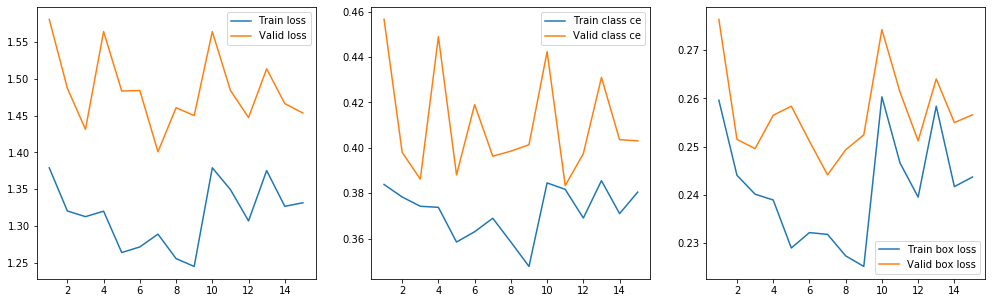

In [9]:
import pandas as pd
# history = model.keras_model.history.history
# epochs = range(1,len(next(iter(history.values())))+1)
# pd.DataFrame(history, index=epochs)

epochs_val = pd.read_csv('output_val/output_val_15e.csv')
epochs=range(1,len(epochs_val)+1)

import matplotlib.pyplot as plt
plt.figure(figsize=(17,5))

plt.subplot(131)
plt.plot(epochs, epochs_val["loss"], label="Train loss")
plt.plot(epochs, epochs_val["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(132)
plt.plot(epochs, epochs_val["mrcnn_class_loss"], label="Train class ce")
plt.plot(epochs, epochs_val["val_mrcnn_class_loss"], label="Valid class ce")
plt.legend()
plt.subplot(133)
plt.plot(epochs, epochs_val["mrcnn_bbox_loss"], label="Train box loss")
plt.plot(epochs, epochs_val["val_mrcnn_bbox_loss"], label="Valid box loss")
plt.legend()

plt.show()

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(17,5))

plt.subplot(131)
plt.plot(epochs, history["loss"], label="Train loss")
plt.plot(epochs, history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(132)
plt.plot(epochs, history["mrcnn_class_loss"], label="Train class ce")
plt.plot(epochs, history["val_mrcnn_class_loss"], label="Valid class ce")
plt.legend()
plt.subplot(133)
plt.plot(epochs, history["mrcnn_bbox_loss"], label="Train box loss")
plt.plot(epochs, history["val_mrcnn_bbox_loss"], label="Valid box loss")
plt.legend()

plt.show()

{'id': '015726', 'source': 'dataset', 'path': 'WiderPerson/Images/015726.jpg', 'annotation': 'WiderPerson/Annotations/015726.jpg.txt'}
WiderPerson/Images/015726.jpg
(1024, 1024, 3)
{'id': '016016', 'source': 'dataset', 'path': 'WiderPerson/Images/016016.jpg', 'annotation': 'WiderPerson/Annotations/016016.jpg.txt'}
WiderPerson/Images/016016.jpg
(1024, 1024, 3)
{'id': '016222', 'source': 'dataset', 'path': 'WiderPerson/Images/016222.jpg', 'annotation': 'WiderPerson/Annotations/016222.jpg.txt'}
WiderPerson/Images/016222.jpg
(1024, 1024, 3)
{'id': '014590', 'source': 'dataset', 'path': 'WiderPerson/Images/014590.jpg', 'annotation': 'WiderPerson/Annotations/014590.jpg.txt'}
WiderPerson/Images/014590.jpg
(1024, 1024, 3)
{'id': '014146', 'source': 'dataset', 'path': 'WiderPerson/Images/014146.jpg', 'annotation': 'WiderPerson/Annotations/014146.jpg.txt'}
WiderPerson/Images/014146.jpg
(1024, 1024, 3)


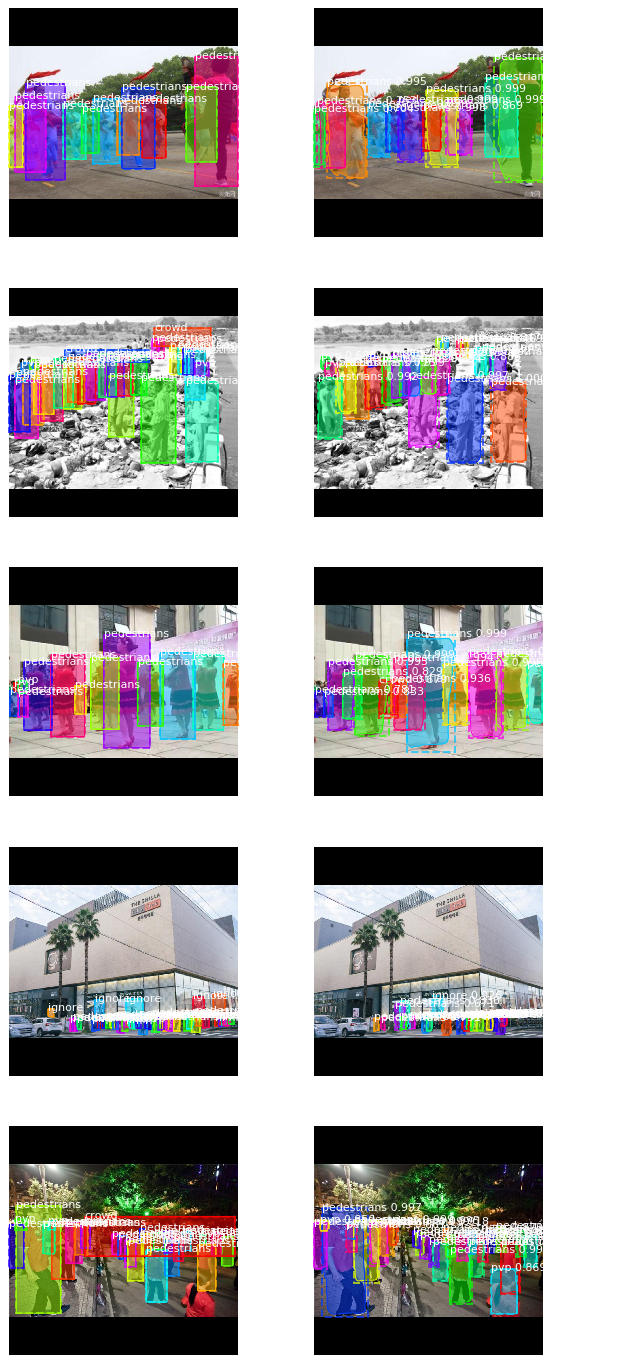

In [19]:
import matplotlib.pyplot as plt
dataset = test_set
fig = plt.figure(figsize=(10, 30))

for i in range(5):

    image_id = random.choice(dataset.image_ids)
    
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(test_set, config,image_id, use_mini_mask=False)
    
    print(original_image.shape)
    plt.subplot(6, 2, 2*i + 1)
    visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                                dataset.class_names,ax=fig.axes[-1])
    
    plt.subplot(6, 2, 2*i + 2)
    results = model.detect([original_image]) #, verbose=1)
    r = results[0]
    visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                                dataset.class_names, r['scores'], ax=fig.axes[-1])

{'id': '000044', 'source': 'dataset', 'path': 'WiderPerson/Images/000044.jpg', 'annotation': 'WiderPerson/Annotations/000044.jpg.txt'}
WiderPerson/Images/000044.jpg
{'id': '000044', 'source': 'dataset', 'path': 'WiderPerson/Images/000044.jpg', 'annotation': 'WiderPerson/Annotations/000044.jpg.txt'}
image ID: dataset.000044 (3) WiderPerson/Images/000044.jpg
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 18)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


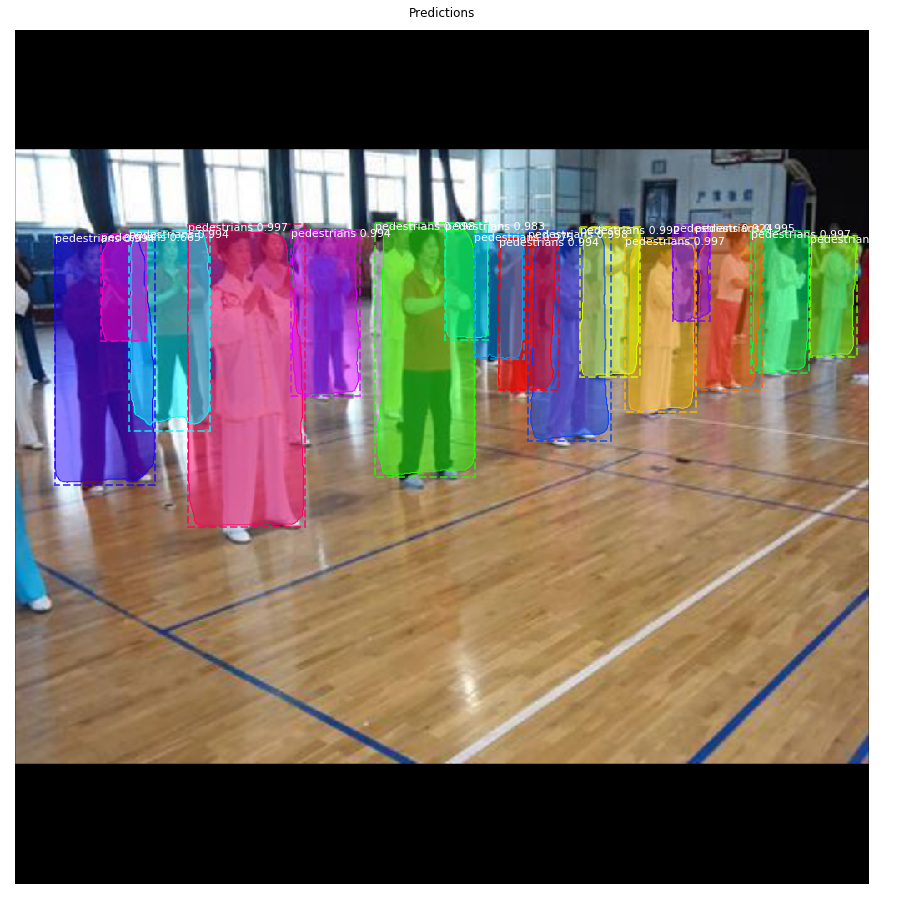

{'id': '000044', 'source': 'dataset', 'path': 'WiderPerson/Images/000044.jpg', 'annotation': 'WiderPerson/Annotations/000044.jpg.txt'}
WiderPerson/Images/000044.jpg
(1024, 1024, 3)


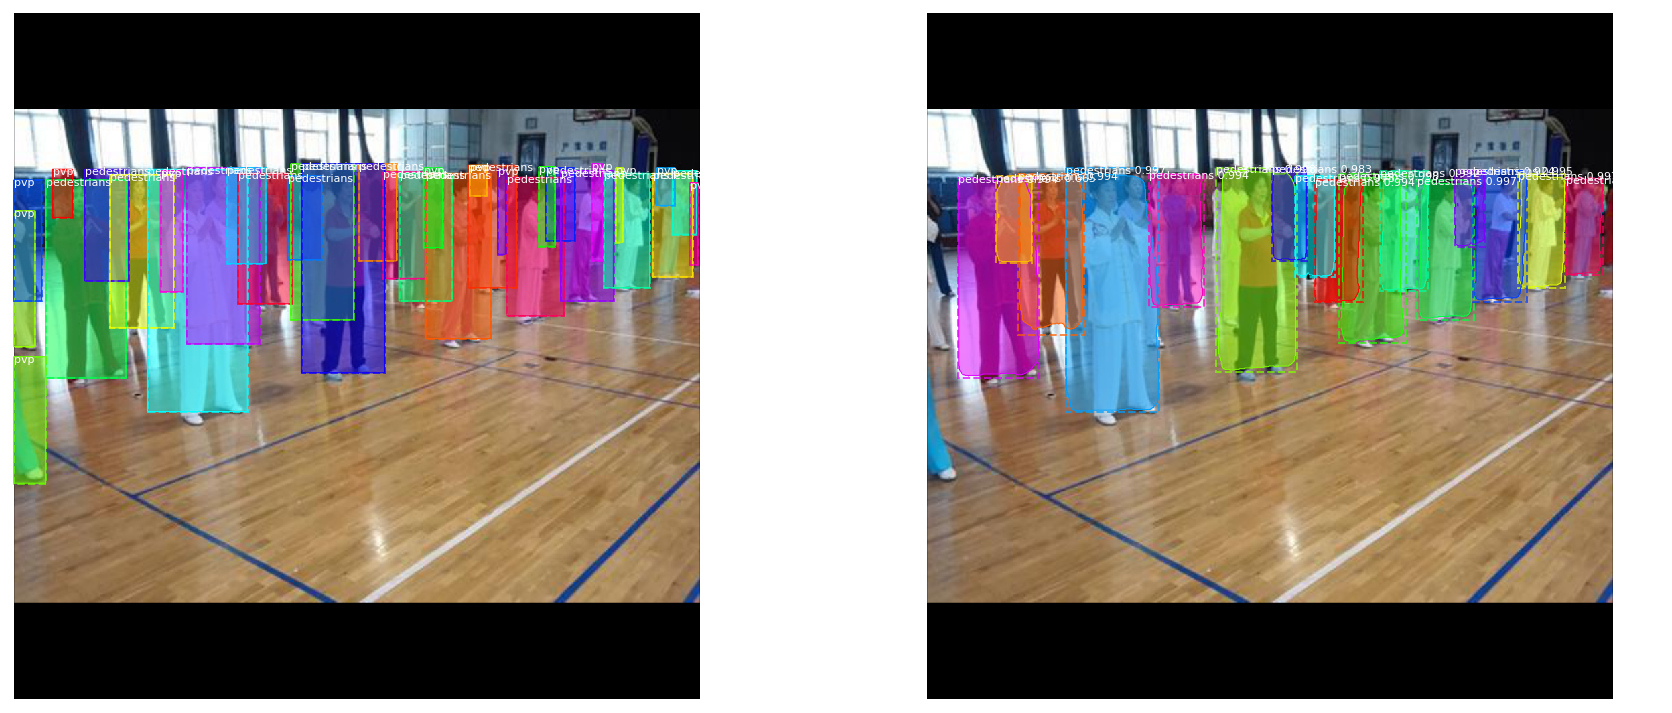

In [14]:
# image_id = 3
# image, image_meta, gt_class_id, gt_bbox, gt_mask =    modellib.load_image_gt(test_set, config, image_id, use_mini_mask=False)
# info = test_set.image_info[image_id]
# print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
#                                        test_set.image_reference(image_id)))
# # Run object detection
# results = model.detect([image], verbose=1)
# # Display results

# r = results[0]
# visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
#                             test_set.class_names, r['scores'], 
#                             title="Predictions")

image_id = 3
image, image_meta, gt_class_id, gt_bbox, gt_mask =    modellib.load_image_gt(train_set, config, image_id, use_mini_mask=False)
info = train_set.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       train_set.image_reference(image_id)))
# Run object detection
results = model.detect([image], verbose=1)
# Display results

r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            train_set.class_names, r['scores'], 
                            title="Predictions")


fig = plt.figure(figsize=(30, 90))
    
original_image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(train_set, config,image_id, use_mini_mask=False)

print(original_image.shape)
plt.subplot(6, 2, 2*i + 1)
visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            train_set.class_names,ax=fig.axes[-1])

plt.subplot(6, 2, 2*i + 2)
results = model.detect([original_image]) #, verbose=1)
r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            train_set.class_names, r['scores'], ax=fig.axes[-1])